In [9]:
# importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
# importing data
df = pd.read_csv('unique_outages.csv', parse_dates=['Start', 'Finish'])
# df = df.replace({r"\r|\n": " "}, regex=True)
# df.columns = df.columns.str.replace(r'[\r\n]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
# df = df.drop(columns=['Status_Description_Market', 'Market_Notice_Code', 'Impact_Region'])
# df = df[df['Unplanned?'] != 1]

from network_asset_extraction import extract_asset_type
df.loc[:, 'Asset Type'] = df['Network Asset'].apply(extract_asset_type)

df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Region              2388 non-null   object        
 1   NSP                 2388 non-null   object        
 2   Start               2294 non-null   datetime64[ns]
 3   Finish              2294 non-null   datetime64[ns]
 4   Network Asset       2388 non-null   object        
 5   Recall_Day_Hours    2388 non-null   int64         
 6   Recall_Night_Hours  2388 non-null   int64         
 7   Project Work?       2388 non-null   int64         
 8   Unplanned?          2388 non-null   int64         
 9   DNSP Aware?         2388 non-null   int64         
 10  Generator Aware?    2388 non-null   int64         
 11  Inter-Regional      2388 non-null   int64         
 12  Status_Description  2385 non-null   object        
 13  Status_Code         1889 non-null   object      

,Region,NSP,Start,Finish,Network Asset,Recall_Day_Hours,Recall_Night_Hours,Project Work?,Unplanned?,DNSP Aware?,Generator Aware?,Inter-Regional,Status_Description,Status_Code,Reason,Duration_Hours,Impact,file_name,Asset Type
0,VIC,AusNet,2024-11-11 06:00:00,2024-11-11 16:00:00,Haunted Gully - Tarrone 500 Kv line,2,0,0,0,0,0,0,Planned,SUBMIT,Maintenance,10.0,A credible contingency event during this plann...,2024-08-26,Line
1,VIC,AusNet,2025-02-04 06:00:00,2025-02-04 16:00:00,Bulgana - Horsham 220 kV Line,60,0,0,0,0,0,0,Planned,SUBMIT,Maintenance,10.0,A credible contingency event during this plann...,2024-08-26,Line
2,VIC,AusNet,2025-03-03 05:00:00,2025-03-03 17:00:00,Kiamal SF-Red Cliffs 220 kV LINE,3,0,0,0,0,0,0,Planned,SUBMIT,Maintenance,12.0,A credible contingency event during this plann...,2024-08-26,Line
3,VIC,AusNet,2025-06-21 07:00:00,2025-06-21 17:00:00,Kiamal SF-Red Cliffs 220 kV LINE,60,0,0,0,0,0,0,Planned,SUBMIT,Maintenance,10.0,A credible contingency event during this plann...,2024-08-26,Line
4,VIC,AusNet,2025-01-27 06:00:00,2025-01-27 16:00:00,MooraboolSydenham No.2 500 kV Line,4,0,0,0,0,0,0,Planned,SUBMIT,Maintenance,10.0,A credible contingency event during this plann...,2024-08-26,Line


In [6]:
# df['Impact'].value_counts()

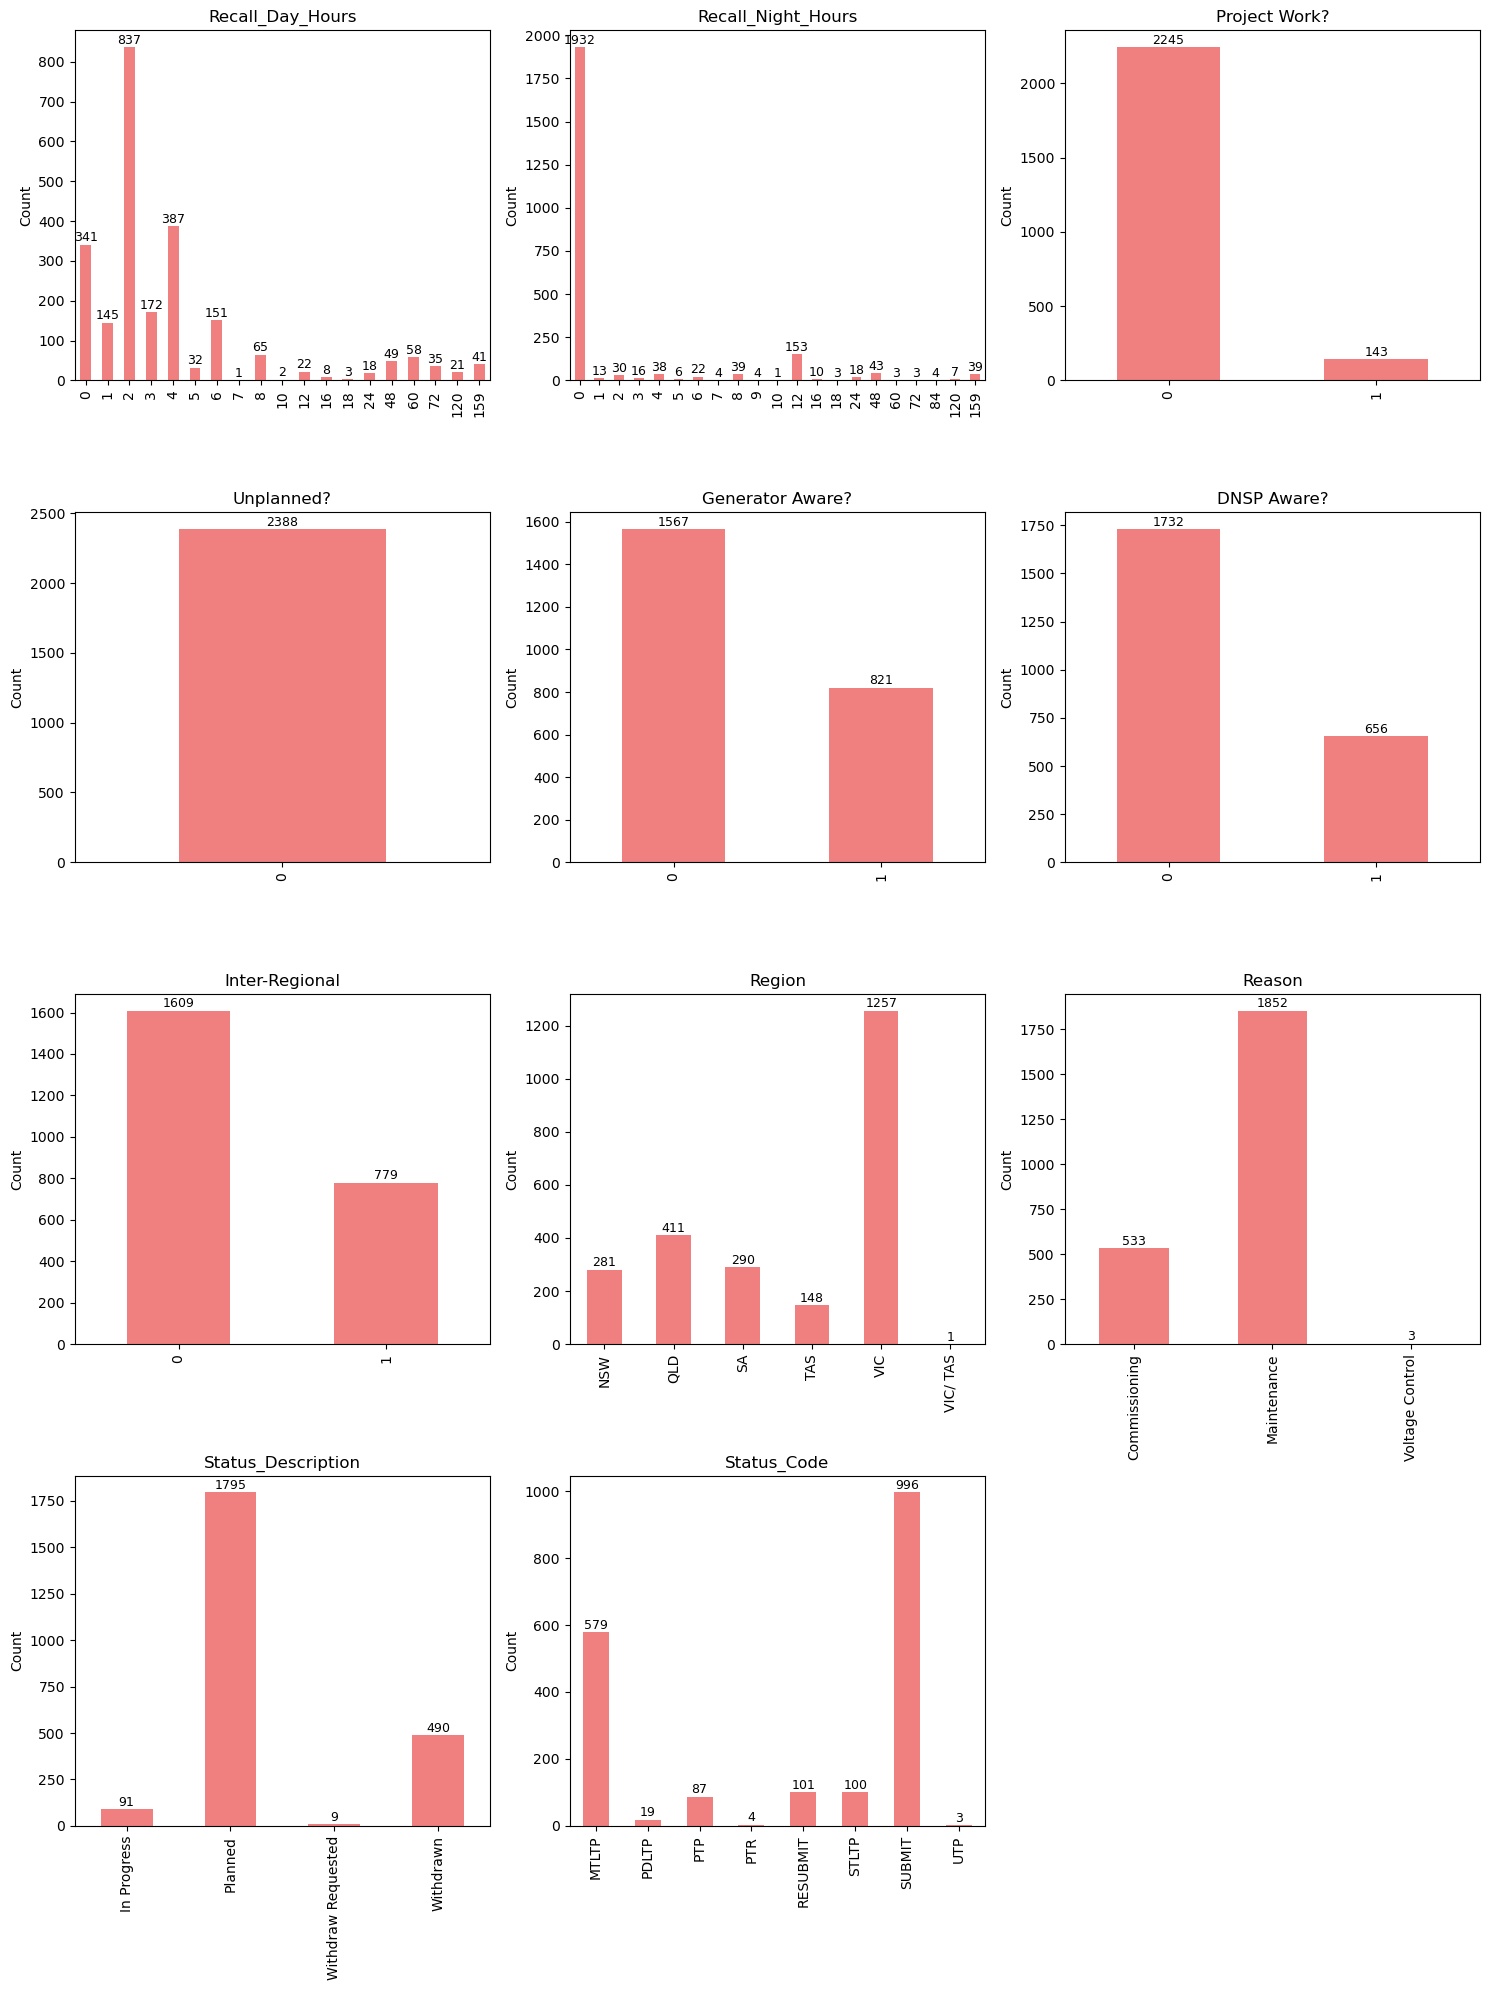

In [7]:
# Visualisation plots for the variables

bool_cols = ['Project Work?', 'Unplanned?', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional']
numeric_cols = ['Recall_Day_Hours', 'Recall_Night_Hours']
categorical_cols = ['Region', 'Reason', 'Status_Description', 'Status_Code']

# Combine all into one list
all_cols = numeric_cols + bool_cols + categorical_cols

n_cols = 3  # number of columns per row
n_rows = (len(all_cols) + n_cols - 1) // n_cols  # compute required rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(all_cols):
    ax = axes[idx]

    # Value counts for categorical/boolean/numeric columns
    counts = df[col].value_counts().sort_index()

    # Plot bar chart
    counts.plot(kind='bar', ax=ax, color='lightcoral')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    # Add value labels on bars
    for i, value in enumerate(counts):
        ax.text(i, value + 1, str(int(value)), ha='center', va='bottom', fontsize=9, rotation=0)

# Remove any unused subplots
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

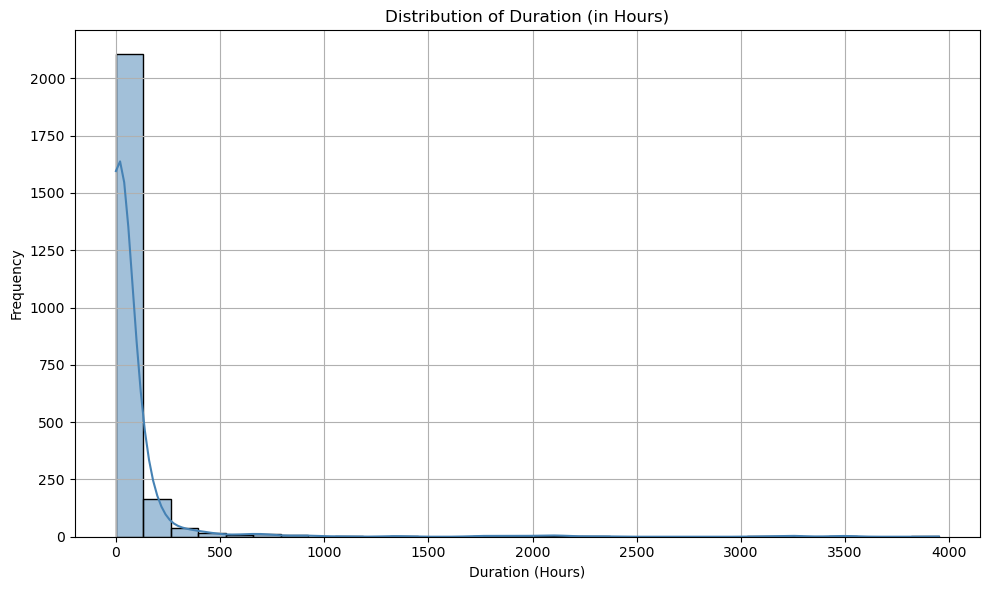

In [8]:
# Plot distribution of output variable 
# Drop NaNs
duration_data = df["Duration_Hours"].dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(duration_data, bins=30, kde=True, color='steelblue')
plt.title("Distribution of Duration (in Hours)")
plt.xlabel("Duration (Hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Drop rows with missing Duration_Hours
df = df.dropna(subset=["Duration_Hours"])

# Define target and input variables, dropping some not needed variables.
y = df["Duration_Hours"]

# Drop columns not useful or that leak the target
X = df.drop(columns=["Duration_Hours", 
                     "Start", "Finish", "Network Asset", "Impact", "file_name"])

# Identify categorical and numeric features
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), categorical_cols),
    ],
    remainder='passthrough'  # keep numeric columns as they are
)

# Create pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
model.fit(X_train, y_train)

NameError: name 'train_test_split' is not defined

In [44]:
# from sklearn.ensemble import RandomForestRegressor
# model = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
# ])

In [45]:
import statsmodels.api as sm

# Preprocess
X_encoded = preprocessor.fit_transform(X)

# Ensure the result is a dense NumPy array (statsmodels requires it)
if hasattr(X_encoded, "toarray"):
    X_encoded = X_encoded.toarray()


# Train-test split
X_train_encoded, X_test_encoded, y_train_, y_test_ = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Add constant for intercept
X_train_encoded_const = sm.add_constant(X_train_encoded)

# Fit model
ols_model = sm.OLS(y_train_, X_train_encoded_const).fit()

# Print summary
print(ols_model.summary())


RMSE: 413.578


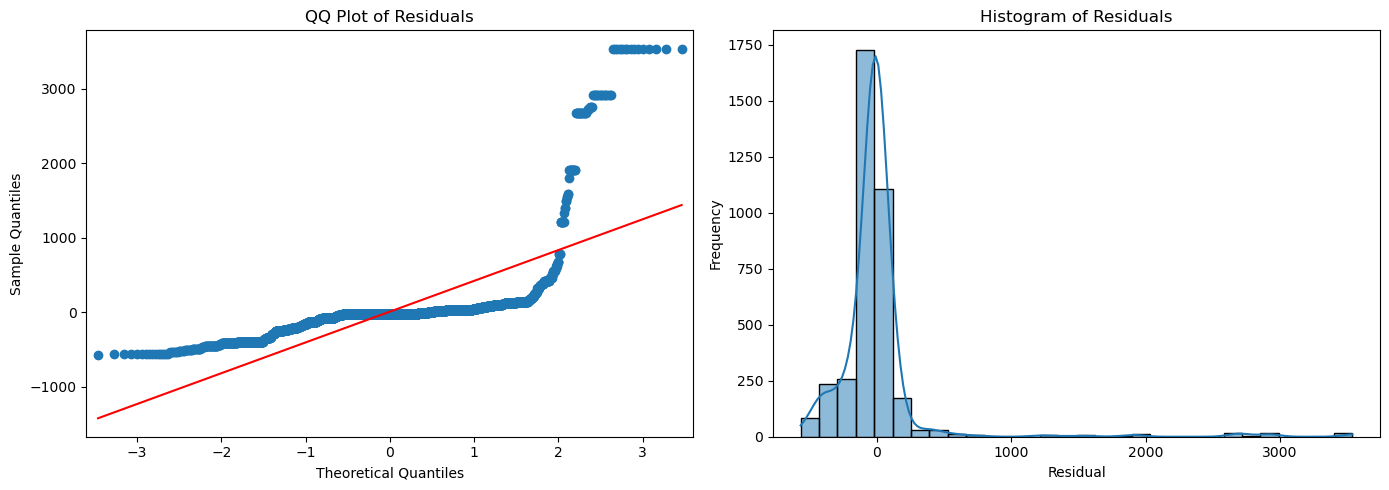

In [46]:
from sklearn.metrics import mean_squared_error

def plot_ols_diagnostics(model, X_test, y_test, X_is_encoded=True):
    # If X_test is not yet encoded and needs to go through the preprocessor
    if not X_is_encoded:
        X_test = preprocessor.transform(X_test)

    # Convert sparse matrix to dense if needed
    if hasattr(X_test, "toarray"):
        X_test = X_test.toarray()

    # Add constant
    X_test_const = sm.add_constant(X_test)

    # Predictions
    y_pred = model.predict(X_test_const)

    # Residuals
    residuals = y_test - y_pred

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.3f}")

    # QQ-Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sm.qqplot(residuals, line='s', ax=axes[0])
    axes[0].set_title("QQ Plot of Residuals")

    # Residual Histogram
    sns.histplot(residuals, kde=True, ax=axes[1], bins=30)
    axes[1].set_title("Histogram of Residuals")
    axes[1].set_xlabel("Residual")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()
plot_ols_diagnostics(ols_model, X_test_encoded, y_test_)

In [52]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_train_encoded, y_train_)

Ridge()

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def ridge_model_summary_with_plots(model, X_train, y_train, X_test, y_test, feature_names=None):
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Residuals
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Coefficients
    if feature_names is None:
        feature_names = [f"X{i}" for i in range(X_train.shape[1])]

    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": model.coef_
    }).sort_values(by="Coefficient", key=np.abs, ascending=False)

    print("📈 Ridge Regression Model Summary")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"R² Score (Train): {r2_train:.4f}")
    print(f"R² Score (Test):  {r2_test:.4f}")
    print(f"RMSE (Train):     {rmse_train:.4f}")
    print(f"RMSE (Test):      {rmse_test:.4f}")
    print("\nTop Coefficients:")
    print(coef_df.head(10).to_string(index=False))

    # Plot residuals
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].scatter(y_train_pred, residuals_train, alpha=0.5)
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title("Train: Predictions vs Residuals")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Residuals")

    axs[1].scatter(y_test_pred, residuals_test, alpha=0.5)
    axs[1].axhline(0, color='red', linestyle='--')
    axs[1].set_title("Test: Predictions vs Residuals")
    axs[1].set_xlabel("Predicted")
    axs[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

    return coef_df

📈 Ridge Regression Model Summary
Intercept: 225.1946
R² Score (Train): 0.1712
R² Score (Test):  0.1807
RMSE (Train):     391.5615
RMSE (Test):      413.5842

Top Coefficients:
                    Feature  Coefficient
remainder__Generator Aware?  -165.852716
            cat__Region_QLD   161.461977
         cat__NSP_Powerlink   161.461977
    cat__Reason_Maintenance  -155.678755
  remainder__Inter-Regional   114.600864
         cat__NSP_Transgrid  -106.748773
cat__Reason_Voltage Control  -101.702132
       cat__Status_Code_PTP    81.548686
       cat__Status_Code_PTR   -75.382044
               cat__NSP_TOA    68.953374


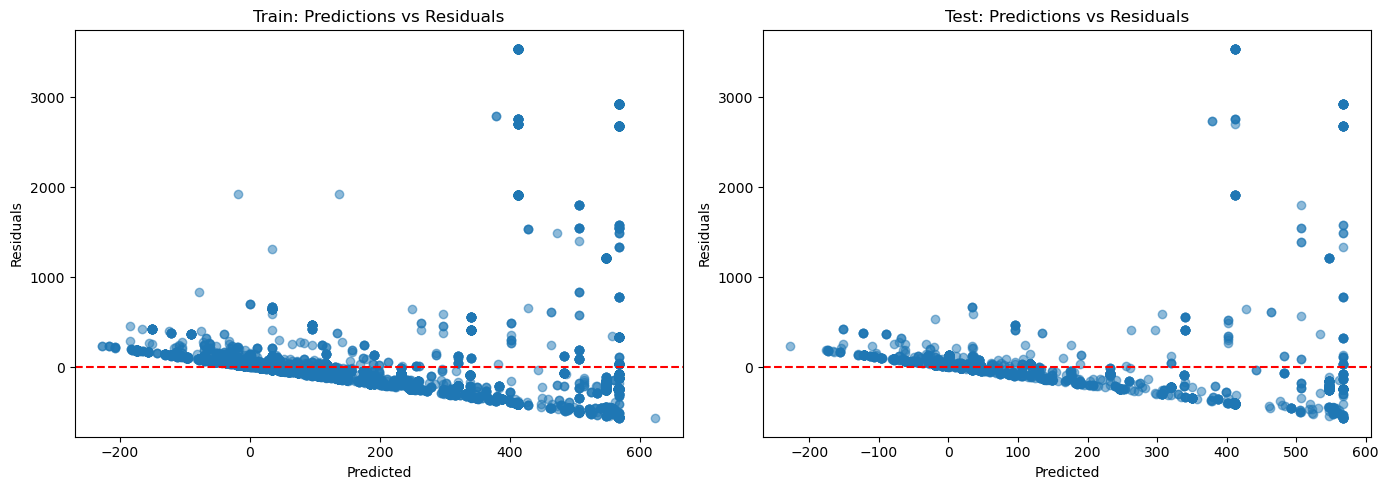

,Feature,Coefficient
28,remainder__Generator Aware?,-165.852716
0,cat__Region_QLD,161.461977
6,cat__NSP_Powerlink,161.461977
21,cat__Reason_Maintenance,-155.678755
29,remainder__Inter-Regional,114.600864
9,cat__NSP_Transgrid,-106.748773
22,cat__Reason_Voltage Control,-101.702132
14,cat__Status_Code_PTP,81.548686
15,cat__Status_Code_PTR,-75.382044
7,cat__NSP_TOA,68.953374


In [56]:
ridge_model_summary_with_plots(
    model,
    X_train_encoded,
    y_train_,
    X_test_encoded,
    y_test_,
    feature_names=preprocessor.get_feature_names_out()  # Optional if you have it
)

## Feature selection

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def drop_high_vif_features(X_encoded, preprocessor, thresh=10.0):
    # Convert to DataFrame with column names from preprocessor
    X_df = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names_out())

    dropped = True
    while dropped:
        dropped = False
        X_df_const = sm.add_constant(X_df)
        
        vif = pd.DataFrame()
        vif["feature"] = X_df_const.columns
        vif["VIF"] = [variance_inflation_factor(X_df_const.values, i) for i in range(X_df_const.shape[1])]

        vif = vif[vif["feature"] != "const"]  # exclude intercept

        max_vif = vif["VIF"].max()
        if max_vif > thresh:
            drop_feature = vif.sort_values(by="VIF", ascending=False).iloc[0]["feature"]
            print(f"Dropping '{drop_feature}' with VIF: {max_vif:.2f}")
            X_df.drop(columns=[drop_feature], inplace=True)
            dropped = True

    return X_df, vif.sort_values(by="VIF", ascending=False)

In [49]:
# After encoding:
X_encoded = preprocessor.fit_transform(X)

# If it's sparse, convert to dense
if hasattr(X_encoded, "toarray"):
    X_encoded = X_encoded.toarray()

# Reduce multicollinearity
X_reduced_df, final_vif = drop_high_vif_features(X_encoded, preprocessor)

# Train/test split with reduced features
X_train, X_test, y_train, y_test = train_test_split(X_reduced_df, y, test_size=0.2, random_state=42)

# Reset index to align exog (X) and endog (y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Continue with OLS
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'cat__Region_QLD' with VIF: inf


c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'cat__Region_SA' with VIF: inf


c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'cat__Region_TAS' with VIF: inf


c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'cat__Region_VIC' with VIF: inf


c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping 'cat__Status_Code_PTP' with VIF: inf


c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping 'cat__Status_Description_Withdraw Requested' with VIF: inf


c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping 'cat__Status_Code_nan' with VIF: 26.73
                            OLS Regression Results                            
Dep. Variable:         Duration_Hours   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     140.1
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:15:19   Log-Likelihood:            -1.1053e+05
No. Observations:               14959   AIC:                         2.211e+05
Df Residuals:                   14936   BIC:                         2.213e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

c:\Users\althi\anaconda3_2\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
